In [100]:
# some basic imports
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [101]:
# predefined for the project as the task is considered as classification in patches
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

In [102]:
if not os.path.isdir('validation'):  # make sure this has not been executed yet
  try:
          !unzip ethz-cil-road-segmentation-2023.zip
          !mv training/training/* training
          !rm -rf training/training
          !mkdir validation
          !mkdir validation/images
          !mkdir validation/groundtruth
          for img in sample(glob("training/images/*.png"), VAL_SIZE):
            os.rename(img, img.replace('training', 'validation'))
            mask = img.replace('images', 'groundtruth')
            os.rename(mask, mask.replace('training', 'validation'))
  except:
      print('Please upload a .zip file containing your datasets.')
else:
    print("Validation folder exists already")

Validation folder exists already


training/images


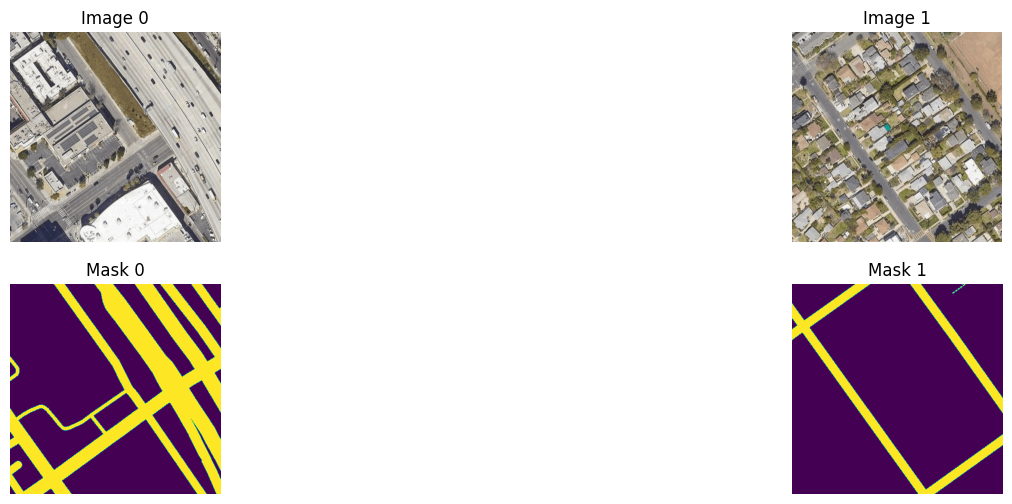

In [104]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


# paths to training and validation datasets
train_path = 'training'
val_path = 'validation'

print(os.path.join(train_path, 'images'))
train_images = load_all_from_path(os.path.join(train_path, 'images'))
train_masks = load_all_from_path(os.path.join(train_path, 'groundtruth'))
val_images = load_all_from_path(os.path.join(val_path, 'images'))
val_masks = load_all_from_path(os.path.join(val_path, 'groundtruth'))

# visualize a few images from the training set
show_first_n(train_images, train_masks, n=2)

In [105]:
print(f"Training samples {len(train_images)}, Validation. samples {len(val_images)}, Shape: {train_images.shape} ")

Training samples 134, Validation. samples 10, Shape: (134, 400, 400, 4) 


In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training using {device}")
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset('training', device, use_patches=False, resize_to=(384, 384))
len(train_dataset.x)

Training using cuda


134

In [107]:
# DELETE AUGMENTATION FOLDER. SET DELETE_AUG = True if you really want to remove it
'''DELETE_AUG = False

if DELETE_AUG:
    !rm -r augmentation'''

'DELETE_AUG = False\n\nif DELETE_AUG:\n    !rm -r augmentation'

In [108]:
# PERFORM DATA AUGMENTATION
transformations = [
    (Image.Transpose.FLIP_LEFT_RIGHT, 'horiflip'),
    (Image.Transpose.FLIP_TOP_BOTTOM, 'vertflip'),
    (Image.Transpose.ROTATE_90, 'rot90'),
    (Image.Transpose.ROTATE_180, 'rot180'),
    (Image.Transpose.ROTATE_270, 'rot270')
                  ]
dest_folder_img = 'augmentation/images'
dest_folder_mask = 'augmentation/groundtruth'
if not os.path.isdir('augmentation'):  # make sure this has not been executed yet
    !mkdir augmentation
    !mkdir augmentation/images
    !mkdir augmentation/groundtruth
    ctr = 0
    for img_path in glob("training/images/*.png"):
        #print(ctr)
        image = Image.open(img_path)

        mask_path = img_path.replace('images', 'groundtruth')
        mask = Image.open(mask_path)

        for (transform, name) in transformations:
            aug_image = image.transpose(transform)
            aug_mask = mask.transpose(transform)

            image_name = os.path.basename(img_path) 
            image_name, image_ext = os.path.splitext(image_name) # get file name and extension

            img_dest_path = os.path.join(dest_folder_img,  name + "_" + image_name  + image_ext)
            mask_dest_path = os.path.join(img_dest_path.replace("images", "groundtruth"))

            aug_image.save(img_dest_path)
            aug_mask.save(mask_dest_path)
            
        ctr += 1
else:
    print("Augmentation folder exists already")


Augmentation folder exists already


In [109]:
def load_all_from_path_by_id(path, idx):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*_' + str(idx) + '.png'))]).astype(np.float32) / 255.


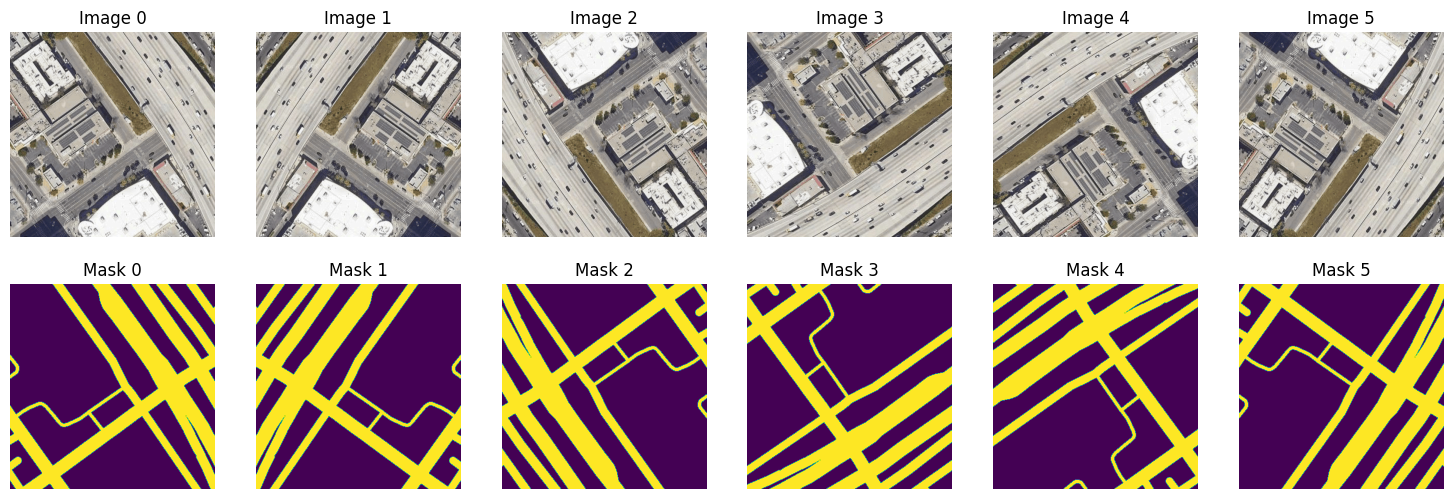

In [111]:
# Show sample for image 0
aug_path = 'augmentation'
idx = 0

original_image = [train_images[idx]]
original_mask = [train_masks[idx]]

aug_images = load_all_from_path_by_id(os.path.join(aug_path, 'images'), idx)
aug_masks = load_all_from_path_by_id(os.path.join(aug_path, 'groundtruth'), idx)

disp_imgs = np.concatenate((original_image, aug_images), axis=0)
disp_masks = np.concatenate((original_mask, aug_masks), axis=0)

len(disp_imgs)
# visualize a few images from the training set
show_first_n(disp_imgs, disp_masks, 10)

In [112]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)


class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, path, device, use_patches=True, use_augmentation=False, resize_to=(400, 400)):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.use_augmentation = use_augmentation
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))[:,:,:,:3]
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        
        if self.use_augmentation:
             # load from augmentation path and concat x and y
            aug_path = 'augmentation'
            aug_x = load_all_from_path(os.path.join(aug_path, 'images'))[:,:,:,:3]
            aug_y = load_all_from_path(os.path.join(aug_path, 'groundtruth'))
            
            self.x = np.concatenate((self.x, aug_x), axis=0)
            self.y = np.concatenate((self.y, aug_y), axis=0)
            
       
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        
        
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))

    def __len__(self):
        return self.n_samples


def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = ImageDataset('training', device, use_patches=False, use_augmentation=False, resize_to=(384, 384))

print(train_dataset.n_samples) # standard dataset has 134
train_dataset._load_data()
train_dataset = ImageDataset('training', device, use_patches=False, use_augmentation=True, resize_to=(384, 384))
print(train_dataset.n_samples) # check if we have more

134
804


In [114]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)

                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        
        if epoch % 10 == 0: # only show after 5 epochs
            show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # saving

    torch.save(model.state_dict(), 'base_unet')

In [115]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder # [::-1] reverse, [:-1] select all until last
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel


def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

In [12]:
chs=(3,64,128,256,512,1024)
chs[::-1][:-1] # reverse it and remove first item

(1024, 512, 256, 128, 64)

Training using cuda


2023-07-09 18:41:41.969591: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.39110092114453293
  	- val_loss = 0.47198111812273663
  	- acc = 0.8279842629064968
  	- val_acc = 0.8404168089230856
  	- patch_acc = 0.7507838492666311
  	- val_patch_acc = 0.7822627226511637
 


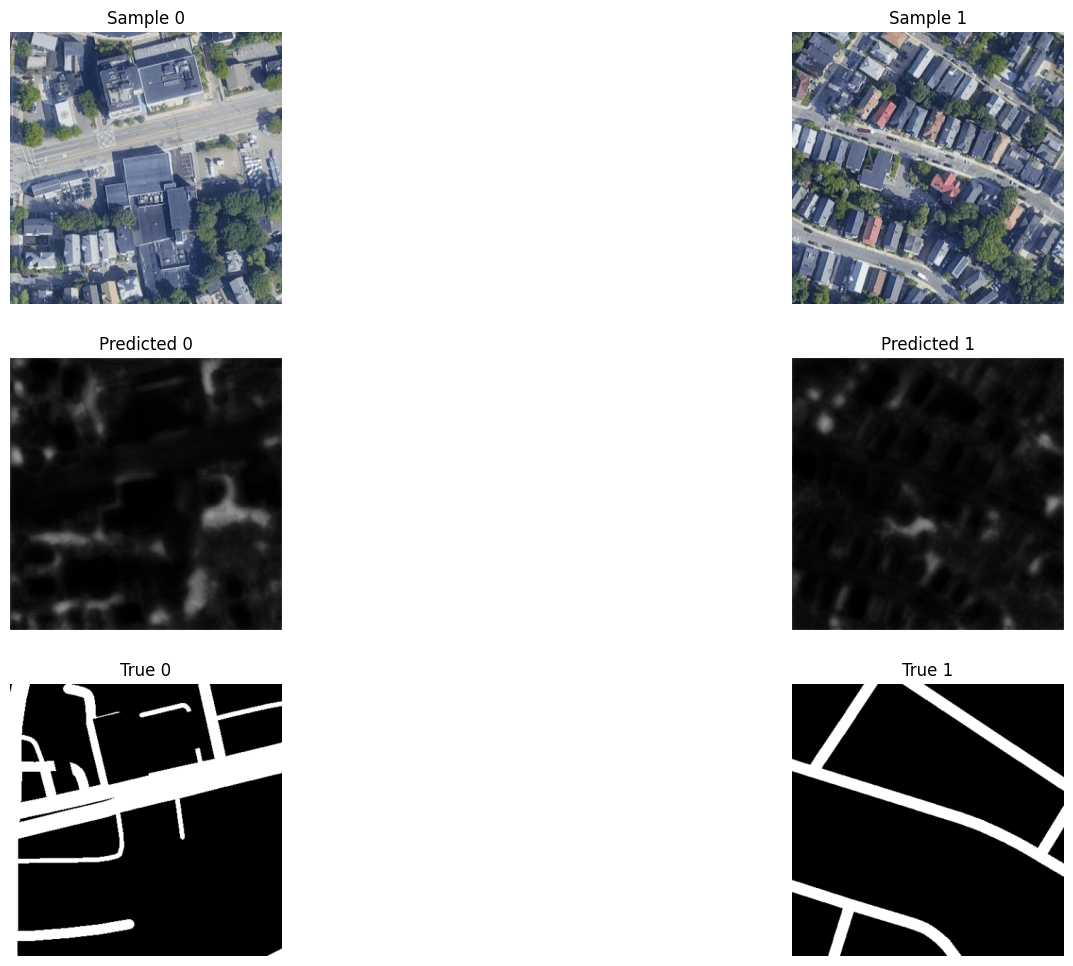

Epoch 2/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.35543177947772675
  	- val_loss = 0.3292647401491801
  	- acc = 0.8463753535972899
  	- val_acc = 0.8629698554674784
  	- patch_acc = 0.7930097826084688
  	- val_patch_acc = 0.8285590410232544
 


Epoch 3/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.3179053785047721
  	- val_loss = 0.33346367875734967
  	- acc = 0.8669139277282639
  	- val_acc = 0.8609687089920044
  	- patch_acc = 0.8285784670962623
  	- val_patch_acc = 0.7965856393178304
 


Epoch 4/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.2882261853016431
  	- val_loss = 0.31896552443504333
  	- acc = 0.8807539515827426
  	- val_acc = 0.864611029624939
  	- patch_acc = 0.8473258768741171
  	- val_patch_acc = 0.8190104166666666
 


Epoch 5/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.25979579399474223
  	- val_loss = 0.2804560561974843
  	- acc = 0.893313613697071
  	- val_acc = 0.8912489215532938
  	- patch_acc = 0.8670471497436067
  	- val_patch_acc = 0.8628472288449606
 


Epoch 6/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.24986440818108135
  	- val_loss = 0.31281479199727374
  	- acc = 0.8982320315209195
  	- val_acc = 0.8848238388697306
  	- patch_acc = 0.8731062631701949
  	- val_patch_acc = 0.8622685074806213
 


Epoch 7/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.2360849143260747
  	- val_loss = 0.2686229149500529
  	- acc = 0.904540061654143
  	- val_acc = 0.8935479124387106
  	- patch_acc = 0.8813830234518099
  	- val_patch_acc = 0.8751446803410848
 


Epoch 8/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.22741935079667105
  	- val_loss = 0.2556634098291397
  	- acc = 0.9079106927511111
  	- val_acc = 0.9042363961537679
  	- patch_acc = 0.887614885372902
  	- val_patch_acc = 0.8872974514961243
 


Epoch 9/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.21951704331446642
  	- val_loss = 0.26031285027662915
  	- acc = 0.9116502599929696
  	- val_acc = 0.9008444547653198
  	- patch_acc = 0.8918493520561143
  	- val_patch_acc = 0.8664641380310059
 


Epoch 10/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.21299868455128884
  	- val_loss = 0.2675425559282303
  	- acc = 0.9140467928416693
  	- val_acc = 0.899169921875
  	- patch_acc = 0.8963256706645832
  	- val_patch_acc = 0.874131957689921
 


Epoch 11/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.2057049032022704
  	- val_loss = 0.25009427467981976
  	- acc = 0.9174164388310256
  	- val_acc = 0.901990552743276
  	- patch_acc = 0.9006637883423573
  	- val_patch_acc = 0.8841146032015482
 


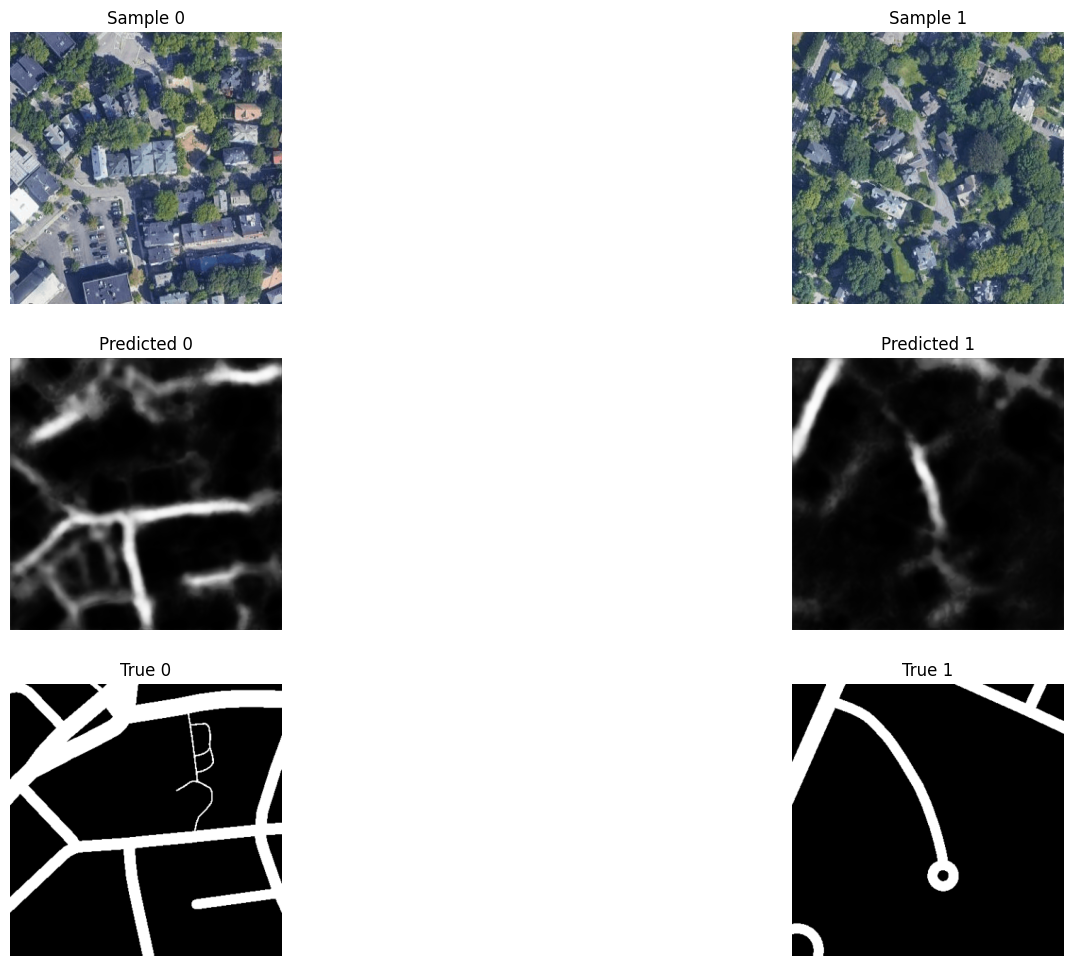

Epoch 12/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.1990587801408412
  	- val_loss = 0.2536000808080037
  	- acc = 0.9203192612425012
  	- val_acc = 0.9024025400479635
  	- patch_acc = 0.9046499349584627
  	- val_patch_acc = 0.8864294091860453
 


Epoch 13/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.18820979720472697
  	- val_loss = 0.25962458550930023
  	- acc = 0.9247835978346678
  	- val_acc = 0.8982707858085632
  	- patch_acc = 0.9110113569160005
  	- val_patch_acc = 0.8576388955116272
 


Epoch 14/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.18657966080441404
  	- val_loss = 0.5778077642122904
  	- acc = 0.9253199577924625
  	- val_acc = 0.8420246243476868
  	- patch_acc = 0.9114734560102966
  	- val_patch_acc = 0.7877604166666666
 


Epoch 15/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.19317512136341922
  	- val_loss = 0.23504855235417685
  	- acc = 0.9220013787497335
  	- val_acc = 0.9117697278658549
  	- patch_acc = 0.9071893196793931
  	- val_patch_acc = 0.8820891380310059
 


Epoch 16/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.17390907974682043
  	- val_loss = 0.22110781570275626
  	- acc = 0.9302579680485512
  	- val_acc = 0.9198987086613973
  	- patch_acc = 0.9190786581727403
  	- val_patch_acc = 0.8969907561937968
 


Epoch 17/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.16762269970344668
  	- val_loss = 0.2680594672759374
  	- acc = 0.9328777155472865
  	- val_acc = 0.8943277994791666
  	- patch_acc = 0.9224666677304169
  	- val_patch_acc = 0.8566261728604635
 


Epoch 18/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.15633836525737943
  	- val_loss = 0.27843280633290607
  	- acc = 0.9372843162930427
  	- val_acc = 0.9080149332682291
  	- patch_acc = 0.9285754463565883
  	- val_patch_acc = 0.8799189925193787
 


Epoch 19/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.1571333963627839
  	- val_loss = 0.2229543924331665
  	- acc = 0.9371110070404128
  	- val_acc = 0.9178263545036316
  	- patch_acc = 0.9285063464843218
  	- val_patch_acc = 0.899305542310079
 


Epoch 20/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.14903114484020727
  	- val_loss = 0.3108421216408412
  	- acc = 0.9403473942434016
  	- val_acc = 0.9076119860013326
  	- patch_acc = 0.9325399988919348
  	- val_patch_acc = 0.8784722487131754
 


Epoch 21/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.1401451414274932
  	- val_loss = 0.2705018272002538
  	- acc = 0.9432116180510071
  	- val_acc = 0.906907836596171
  	- patch_acc = 0.9370789344037943
  	- val_patch_acc = 0.877314825852712
 


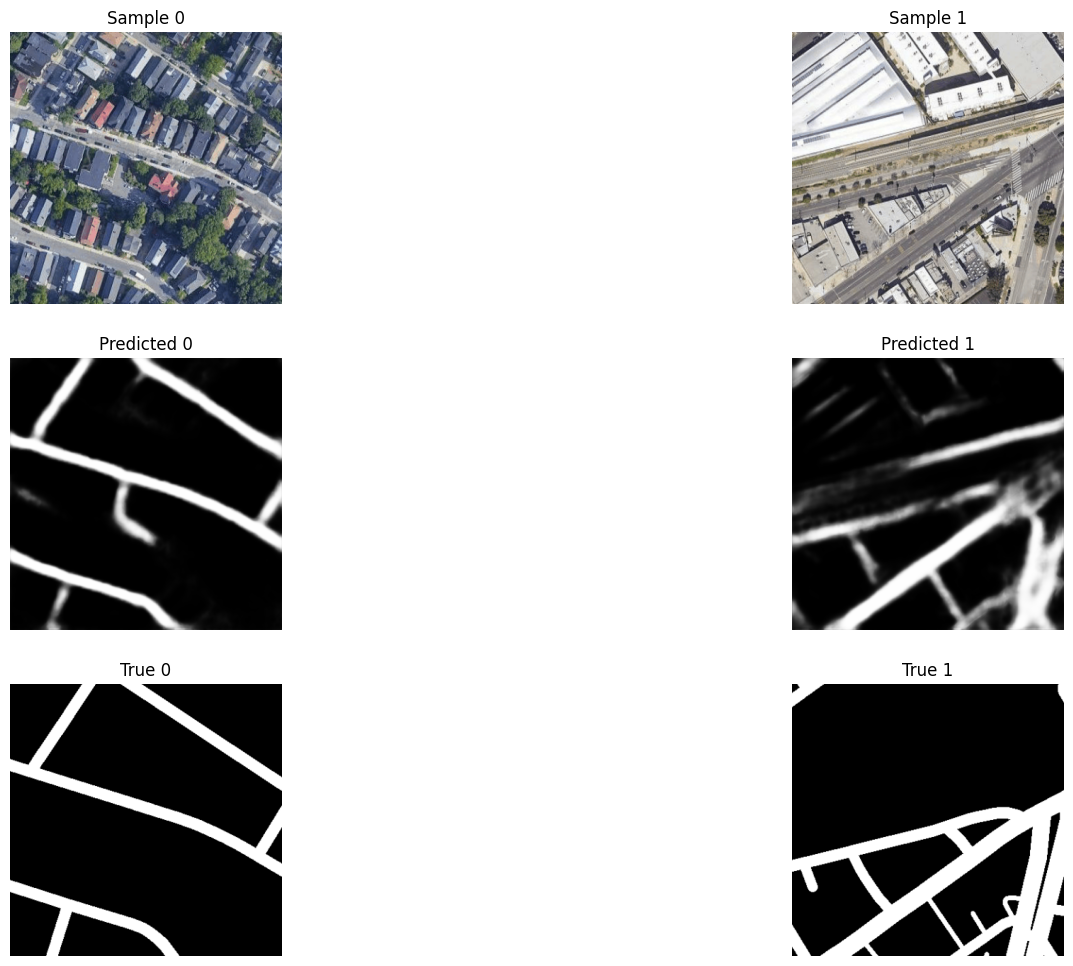

Epoch 22/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.13188975278417864
  	- val_loss = 0.25324924290180206
  	- acc = 0.9467615016657321
  	- val_acc = 0.907880425453186
  	- patch_acc = 0.9419828033565882
  	- val_patch_acc = 0.8742766380310059
 


Epoch 23/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.1220230003865204
  	- val_loss = 0.3396504521369934
  	- acc = 0.9506729719650686
  	- val_acc = 0.9068004488945007
  	- patch_acc = 0.9473098979067447
  	- val_patch_acc = 0.8864293893178304
 


Epoch 24/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.11447576889351233
  	- val_loss = 0.31604257225990295
  	- acc = 0.9533240798100904
  	- val_acc = 0.910569945971171
  	- patch_acc = 0.9509116790780974
  	- val_patch_acc = 0.8861400485038757
 


Epoch 25/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.12073219804769725
  	- val_loss = 0.27641941606998444
  	- acc = 0.9508196738228869
  	- val_acc = 0.9070813457171122
  	- patch_acc = 0.9475107181131543
  	- val_patch_acc = 0.8838252226511637
 


Epoch 26/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.1084453256532031
  	- val_loss = 0.2712687700986862
  	- acc = 0.955913712729269
  	- val_acc = 0.910810112953186
  	- patch_acc = 0.9535935856216583
  	- val_patch_acc = 0.8825231591860453
 


Epoch 27/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.10205103796142251
  	- val_loss = 0.3324325382709503
  	- acc = 0.9584223690317638
  	- val_acc = 0.9124863346417745
  	- patch_acc = 0.9574890379881977
  	- val_patch_acc = 0.889756957689921
 


Epoch 28/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.09264754481724839
  	- val_loss = 0.3062397340933482
  	- acc = 0.9620287498431419
  	- val_acc = 0.9077950914700826
  	- patch_acc = 0.9620474075796592
  	- val_patch_acc = 0.8810763955116272
 


Epoch 29/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.08743576770324019
  	- val_loss = 0.31076380610466003
  	- acc = 0.9641699992602144
  	- val_acc = 0.9165293375651041
  	- patch_acc = 0.9645241748041181
  	- val_patch_acc = 0.895254651705424
 


Epoch 30/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.08268487868617423
  	- val_loss = 0.3583287497361501
  	- acc = 0.9660599053795658
  	- val_acc = 0.8930568099021912
  	- patch_acc = 0.9670052584724047
  	- val_patch_acc = 0.862413207689921
 


Epoch 31/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.08464673799068774
  	- val_loss = 0.3696036438147227
  	- acc = 0.9652625022835992
  	- val_acc = 0.9007647434870402
  	- patch_acc = 0.9659061532708543
  	- val_patch_acc = 0.8777488470077515
 


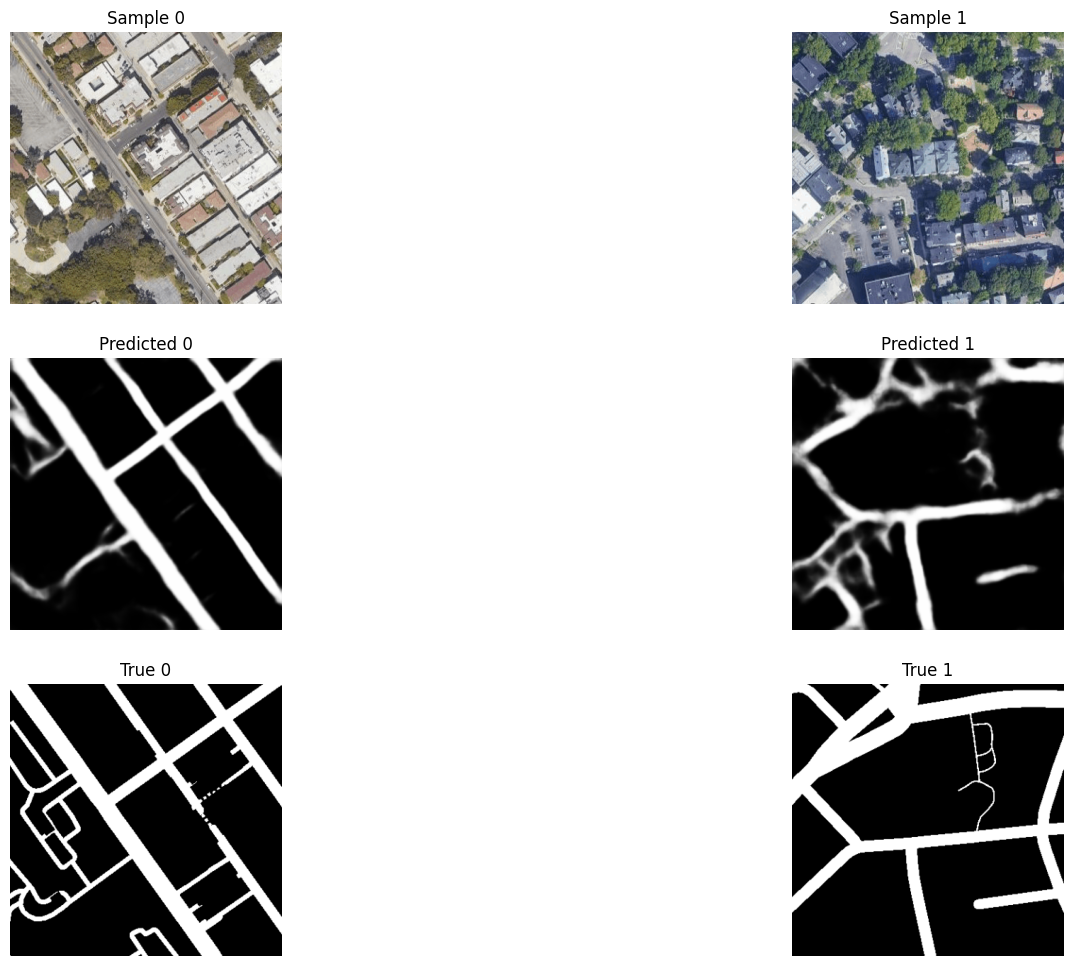

Epoch 32/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.07539303658242842
  	- val_loss = 0.2978656589984894
  	- acc = 0.9690972213721394
  	- val_acc = 0.9164016246795654
  	- patch_acc = 0.9706156787587635
  	- val_patch_acc = 0.893663207689921
 


Epoch 33/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.07339482780416214
  	- val_loss = 0.3170381635427475
  	- acc = 0.9699716476065603
  	- val_acc = 0.909332275390625
  	- patch_acc = 0.9717730859025794
  	- val_patch_acc = 0.8868634303410848
 


Epoch 34/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.06925422423959371
  	- val_loss = 0.3911312719186147
  	- acc = 0.971745670731388
  	- val_acc = 0.904048224290212
  	- patch_acc = 0.9734487370472049
  	- val_patch_acc = 0.885127325852712
 


Epoch 35/35:   0%|          | 0/201 [00:00<?, ?it/s]

	- loss = 0.06380895161954918
  	- val_loss = 0.3429544468720754
  	- acc = 0.9739024413758842
  	- val_acc = 0.9086801012357076
  	- patch_acc = 0.9762774729610082
  	- val_patch_acc = 0.8899016380310059
 
Finished Training


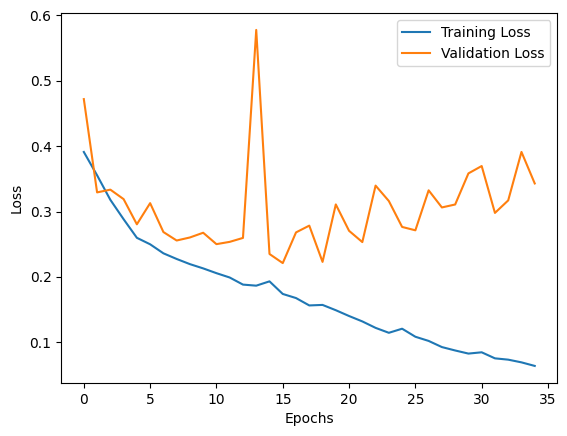

In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training using {device}")
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset('training', device, use_patches=False, use_augmentation=True, resize_to=(384, 384))
val_dataset = ImageDataset('validation', device, use_patches=False, use_augmentation=False, resize_to=(384, 384))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)
model = UNet().to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 35
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)

In [117]:
def create_submission(labels, test_filenames, submission_filename):
    test_path='test/images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

test_path = 'test/images'

In [118]:
# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0] # number of test images
size = test_images.shape[1:3] #WH of images (currently its 400x400 -> reshape to 384x384 for model)
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = test_images[:, :, :, :3] # only get first three channels
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device) # switch from HWC to CWH
test_pred = [model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)] # use our model to predict segmentation mask
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape

# now test_pred has shape (144, 400, 400), for each image the pixel have values 0-1.

# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE)) # split in patches
test_pred = np.moveaxis(test_pred, 2, 3) # move dimension 16x16 together
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF) # mean of 16x16, classify 0 or 1
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')

(144, 25, 16, 25, 16)

(144, 25, 25, 16, 16)